In [2]:
# load necessary library
suppressPackageStartupMessages(library(GEOquery))
suppressPackageStartupMessages(library(oligo))

In [11]:
create.folders<-function(folder_names=NULL,location="."){
#     pass names or paths to create multiple folders 
#     and returns list of status as boolean

    paths<-file.path(location, folder_names)
    is_exists<-dir.exists(paths)
    paths<-paths[!is_exists]
    lapply(paths,function(path){
        dir.create(path, recursive = TRUE)
    })
    return(!is_exists)
    
}

remove.folders<-function(location=".",folder_names=NULL){
#   pass names or paths to remove multiple folders  
#   and returns list of boolean, if it now exists 
    
    paths<-file.path(location, folder_names)
    unlink(paths, recursive= T)
    return(!dir.exists(paths))
}

find.all.indeces<-function(query_list, vector){  
#   returns all matched indeces as a list.
    sapply(query_list,function(query) grep(query,vector))
}
           
extract_from_vector<-function(query_list, vector){
    store<-unique(unlist(lapply(query_list, function(query) grep(query, vector))
                  ))
    return(vector[store])
}
           
group_by_query<-function(query_names, vector, group_names=NULL){
#     it allocates group with first group name that matched if provided.
#     Otherwise allocate query name
    group<-rep(NA,length(vector))
    for(i in 1:length(vector)){
        for(j in 1:length(query_names)){
            if(is.na(group[i]) && !is.na(pmatch(query_names[j],vector[i])))
                if(!is.null(group_names) &&
                   length(group_names)==length(query_names))
                    group[i]<-group_names[j]
                else{group[i]<-query_names[j]}
            }
        }
      return(group)  
}
           
# if group_by_query fuction don't works due to query issues the use this
group_by_numbering<-function(group_numbering, vector, group_names=NULL){
#     gsub(pattern, replacement, string)
    group_numbering<- gsub(" ","",group_numbering)
    group <- rep(NA,length(vector))
    for (i in 1:nchar(group_numbering)){
        num<-as.numeric(substr(group_numbering,i,i))
        if(is.null(group_names)) 
            group[i] <- num
        else group[i] <- group_names[num]
        }
    return(group)
}
           
group_by_uniqueness<- function(vector, group_names=NULL){
    if(is.null(group_names)){
        uniq<- unique(vector)
        rename<-1:length(uniq)
        names(rename)<-uniq
        return(unname(rename[vector]))
    } 
    else {
        uniq<- unique(vector)
        names(group_names)<-uniq
        return(unname(group_names[vector]))
    }
}

fetch.geo.data<-function(GEO,filename=NULL,store_loc="."){
#     fetch published processed data and metadata from GEO database
    suppressPackageStartupMessages(library(GEOquery))
    if(!is.null(filename)) create.folders(file.path(store_loc,filename))
    else create.folders(filename)
    geo.data <- getGEO(GEO, filename=filename, destdir=store_loc, 
                     GSEMatrix=FALSE, AnnotGPL=TRUE, 
                     getGPL=TRUE)
    return(geo.data)
}

need.log.transformation<- function(data){
    qx <- as.numeric(quantile(data, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    # check if data need to be normalized 
    LogC <- (qx[5] > 100) ||
            (qx[6]-qx[1] > 50 && qx[2] > 0) ||
            (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    return(LogC)
}

sort.data<- function(data,columns,dec=FALSE){
    return(data[order(data[,columns],decreasing=dec),])
}

del.duplication<- function(data,column){
    return(data[!duplicated(data[,column]),])
}
           
setup_folder<-function(id){
    # create and set working directory if not exists
    if(!identical(tail(unlist(strsplit(getwd(), split = "/")), n=1), id)){
        if(!dir.exists(id)) {
        create.folders(id)
        setwd(dir =id )
    }
    else setwd(dir =id )
} 
}

In [12]:
# declare ccession number
my.gse<-c("GSE32427")
# set working directory
setup_folder(my.gse)
getwd()

[1] "D:/biological data analysis/Parasites/Plasmodium falciparum 3D7/GSE32427"

# Using GEOquery to Obtain Microarray Data<br>

The GEOquery package allows you to programmatically access data from GEO. Depending on your needs, you can download only the processed data and metadata provided by the depositor. In some cases, you may want to download the raw data as well, if it was provided by the depositor.

In [5]:
# create directory to store files downloaded from GEO and results anlyzed
create.folders(c("geo_downloads","results"))

[1] FALSE FALSE

In [6]:
#get published processed data and metadata from GEO
geo.gse <- getGEO(GEO=my.gse, filename=NULL, destdir="./geo_downloads", 
                     GSElimits=NULL, GSEMatrix=TRUE, AnnotGPL=FALSE, 
                     getGPL=FALSE)
geo.gse

Found 1 file(s)

GSE32427_series_matrix.txt.gz

Using locally cached version: ./geo_downloads/GSE32427_series_matrix.txt.gz


-- Column specification -----------------------------------------------------------
cols(
  ID_REF = col_character(),
  GSM802515 = col_double(),
  GSM802516 = col_double(),
  GSM802517 = col_double(),
  GSM802518 = col_double(),
  GSM802519 = col_double(),
  GSM802520 = col_double(),
  GSM802521 = col_double(),
  GSM802522 = col_double(),
  GSM802523 = col_double(),
  GSM802524 = col_double(),
  GSM802525 = col_double(),
  GSM802526 = col_double(),
  GSM802527 = col_double(),
  GSM802528 = col_double()
)




$GSE32427_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 8993 features, 14 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM802515 GSM802516 ... GSM802528 (14 total)
  varLabels: title geo_accession ... strain:ch1 (34 total)
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
  pubMedIds: 22021236
22347997 
Annotation: GPL16542 


In [7]:
# data available from only one platform GPL16025
my.geo.gse <- geo.gse[[1]]
# object is now an ExpressionSet
class(my.geo.gse)

[1] "ExpressionSet"
attr(,"package")
[1] "Biobase"

In [8]:
# The phenotype data is contained inside pData slot. 
head(pData(my.geo.gse),3)
dim(pData(my.geo.gse))
# the expression matrix is contained inside exprs slot
head(exprs(my.geo.gse),3)
dim(exprs(my.geo.gse))

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,data_row_count,developmental stage:ch1,strain:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GSM802515,Oocyst d0a (unsporulated),GSM802515,Public on Oct 01 2011,Sep 27 2011,Jan 24 2013,RNA,1,Toxoplasma oocyst,Toxoplasma gondii,developmental stage: oocyst unsporulated 0d,...,Stanford University,"Fairchild Bld, 299 Campus Drive D305",Stanford,California,94305-5124,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM802nnn/GSM802515/suppl/GSM802515_1-O-d0a_Tgondiia520372_.cel.CEL.gz,8993,oocyst unsporulated 0d,M4
GSM802516,Oocyst d0b (unsporulated),GSM802516,Public on Oct 01 2011,Sep 27 2011,Jan 24 2013,RNA,1,Toxoplasma oocyst,Toxoplasma gondii,developmental stage: oocyst unsporulated 0d,...,Stanford University,"Fairchild Bld, 299 Campus Drive D305",Stanford,California,94305-5124,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM802nnn/GSM802516/suppl/GSM802516_2-O-d0b_Tgondiia520372_.cel.CEL.gz,8993,oocyst unsporulated 0d,M4
GSM802517,Oocyst d4a (sporulated 4 days),GSM802517,Public on Oct 01 2011,Sep 27 2011,Jan 24 2013,RNA,1,Toxoplasma oocyst,Toxoplasma gondii,developmental stage: oocyst sporulated 4d,...,Stanford University,"Fairchild Bld, 299 Campus Drive D305",Stanford,California,94305-5124,USA,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM802nnn/GSM802517/suppl/GSM802517_3-O-d4b_Tgondiia520372_.cel.CEL.gz,8993,oocyst sporulated 4d,M4


[1] 14 34

,GSM802515,GSM802516,GSM802517,GSM802518,GSM802519,GSM802520,GSM802521,GSM802522,GSM802523,GSM802524,GSM802525,GSM802526,GSM802527,GSM802528
1.m00014_at,3.942621,4.156183,3.272587,3.793467,4.392996,4.359098,4.993529,5.491877,6.418639,6.045306,5.262235,5.509741,5.567717,5.642813
10.m00080_s_at,7.027229,7.607182,6.064970,5.902673,5.334666,5.070197,7.089582,6.865878,5.679106,5.737282,6.350179,6.280475,6.004127,5.638085
10.m00081_at,3.723983,3.447777,3.461100,3.428400,3.420734,3.365810,3.122956,3.582209,3.423787,3.353906,3.291741,3.775153,3.475880,3.484804


[1] 8993   14

In [9]:
pData(my.geo.gse)$title

[1] "Oocyst d0a (unsporulated)"        "Oocyst d0b (unsporulated)"       
 [3] "Oocyst d4a (sporulated 4 days)"   "Oocyst d4b (sporulated 4 days)"  
 [5] "Oocyst d10a (sporulated 10 days)" "Oocyst d10b (sporulated 10 days)"
 [7] "In vivo Bradyzoites a (21 dpi)"   "In vivo Bradyzoites b (21 dpi)"  
 [9] "2 dpi in vitro Tachyzoite a"      "2 dpi in vitro Tachyzoite b"     
[11] "4 dpi in vitro Bradyzoites a"     "4 dpi in vitro Bradyzoites b"    
[13] "8 dpi in vitro Bradyzoites a"     "8 dpi in vitro Bradyzoites b"

***Samples present are:***<br>
`(unsporualted+ mid-sporulation+ fully-sporulated) 2 replicates = 6 samples`
`(2 vivo Bradyzoites + 6 vitro 2 dpi Brazyzoites)= 8 samples`
`()`
days postinfection means (dpi)

# Preparing the Phenodata

In [10]:
# make data frame of phenotypic Data
pdata <- as.data.frame(pData(my.geo.gse), stringsAsFactors=F)

names<-c("title","geo_accession","source_name","organism","species" ,"strain","time")
my.pdata<- pdata[,extract_from_vector(names, colnames(pdata))]
head(my.pdata,2)

,title,geo_accession,source_name_ch1,organism_ch1,strain:ch1
,<chr>,<chr>,<chr>,<chr>,<chr>
GSM802515,Oocyst d0a (unsporulated),GSM802515,Toxoplasma oocyst,Toxoplasma gondii,M4
GSM802516,Oocyst d0b (unsporulated),GSM802516,Toxoplasma oocyst,Toxoplasma gondii,M4


In [11]:
group_num<-c("11 22 33 44 55 66 77")
group_names<-c("Oocyst_0d","Oocyst_4d",
             "Oocyst_10d","Brady_21dpi_vivo",
             "Tachy_2dpi_vitro","Brady_4dpi_vitro",
             "Brady_8dpi_vitro"
              )
# allocate groups
my.pdata[["group"]]<-group_by_numbering(group_num, pdata$title, group_names)
# num of replicates in each group
table(my.pdata$group)


Brady_21dpi_vivo Brady_4dpi_vitro Brady_8dpi_vitro        Oocyst_0d 
               2                2                2                2 
      Oocyst_10d        Oocyst_4d Tachy_2dpi_vitro 
               2                2                2 

In [121]:
suppressPackageStartupMessages(library(RColorBrewer))
# select colour for each group
group.color <- brewer.pal(7, "Dark2")
names(group.color)<-unique(my.pdata$group)
# allocate colour to each sample
sample.color <- unname(group.color[my.pdata$group])
my.pdata[["color"]]<- sample.color
sample.color

[1] "#1B9E77" "#1B9E77" "#D95F02" "#D95F02" "#7570B3" "#7570B3" "#E7298A"
 [8] "#E7298A" "#66A61E" "#66A61E" "#E6AB02" "#E6AB02" "#A6761D" "#A6761D"

In [122]:
# store processed phenotype data
write.table(my.pdata, file=paste0("results/",my.gse,"_PhenoData.txt"), 
            sep="\t", quote=F,col.names=NA)

# Preparing Gene Expression Data<br>

## Normalize Expression Data

In [14]:
assayData<-exprs(my.geo.gse)
# check if data need to be normalized 
LogC<-need.log.transformation(assayData)
LogC

[1] FALSE

In [15]:
if (LogC) { 
    assayData[which(assayData<= 0)] <- NaN
    # take log2 transform
    assayData<-na.omit(log2(assayData))
}
# prpare an Expression Set
my.rma<-ExpressionSet(assayData=assayData,
                      phenoData=AnnotatedDataFrame(my.pdata))
head(exprs(my.rma),3)

,GSM802515,GSM802516,GSM802517,GSM802518,GSM802519,GSM802520,GSM802521,GSM802522,GSM802523,GSM802524,GSM802525,GSM802526,GSM802527,GSM802528
1.m00014_at,3.942621,4.156183,3.272587,3.793467,4.392996,4.359098,4.993529,5.491877,6.418639,6.045306,5.262235,5.509741,5.567717,5.642813
10.m00080_s_at,7.027229,7.607182,6.064970,5.902673,5.334666,5.070197,7.089582,6.865878,5.679106,5.737282,6.350179,6.280475,6.004127,5.638085
10.m00081_at,3.723983,3.447777,3.461100,3.428400,3.420734,3.365810,3.122956,3.582209,3.423787,3.353906,3.291741,3.775153,3.475880,3.484804


In [16]:
# save expression values
write.table(exprs(my.rma), file=paste0("results/",my.gse,"_NormExprsData.txt"),
            sep="\t", quote=FALSE, col.names=NA)

## Check Normalization

In [17]:
suppressPackageStartupMessages(library(limma))

In [18]:
create.folders(c("results/SamplesPlot"))

[1] FALSE

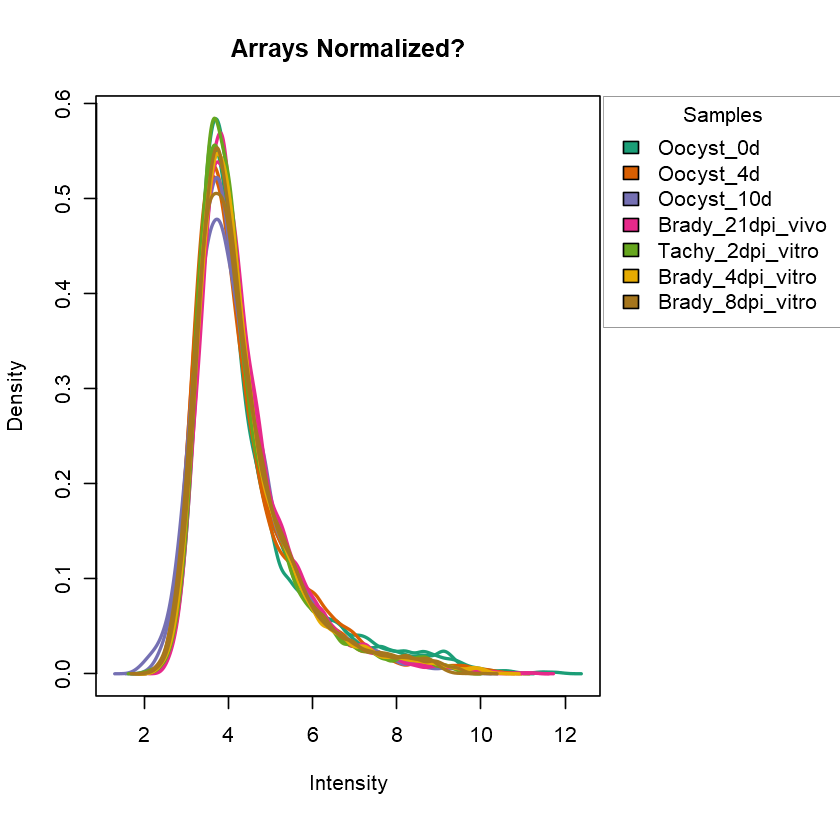

In [123]:
# svg("results/SamplesPlot/DensityPlot.svg")
par(mar=c(6,4,4,10),xpd=TRUE)
plotDensities(exprs(my.rma), legend=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.48,0),box.lwd=0.2, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

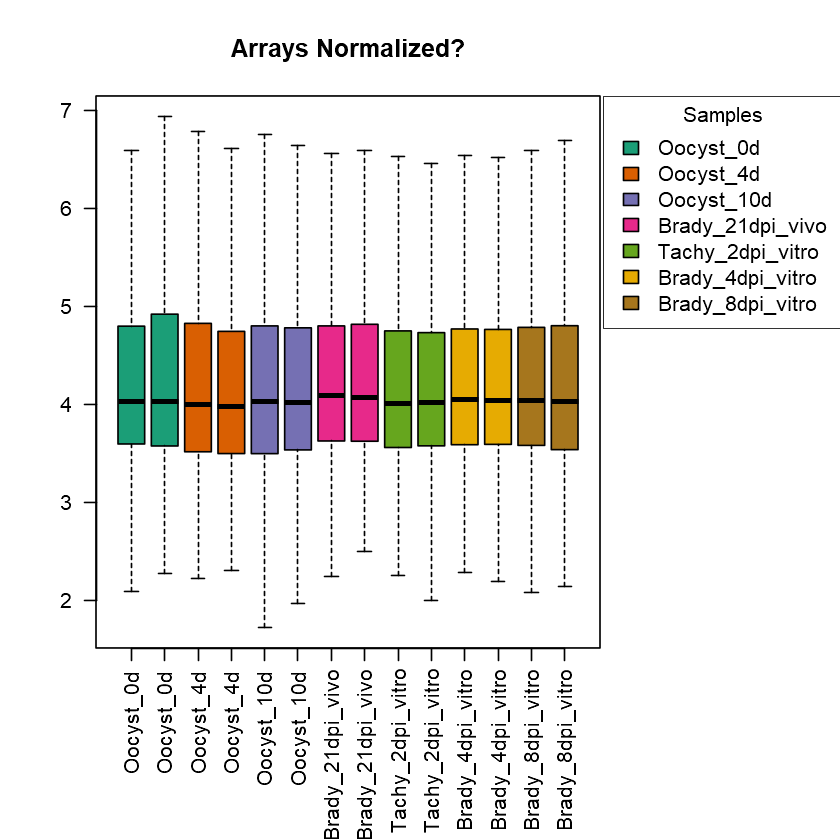

In [125]:
# svg("results/SamplesPlot/BoxPlot.svg")
par(mar=c(8,4,4,10),xpd=TRUE)
boxplot(exprs(my.rma), las=2, names=pData(my.rma)$group, 
        outline=F, col=sample.color, main="Arrays Normalized?")
legend("topright",title="Samples",inset=c(-0.48,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()

## Checking variation across sample<br>
we are mainly checking for consistency between biological replicates of the same treatment.

### Principle component analysis

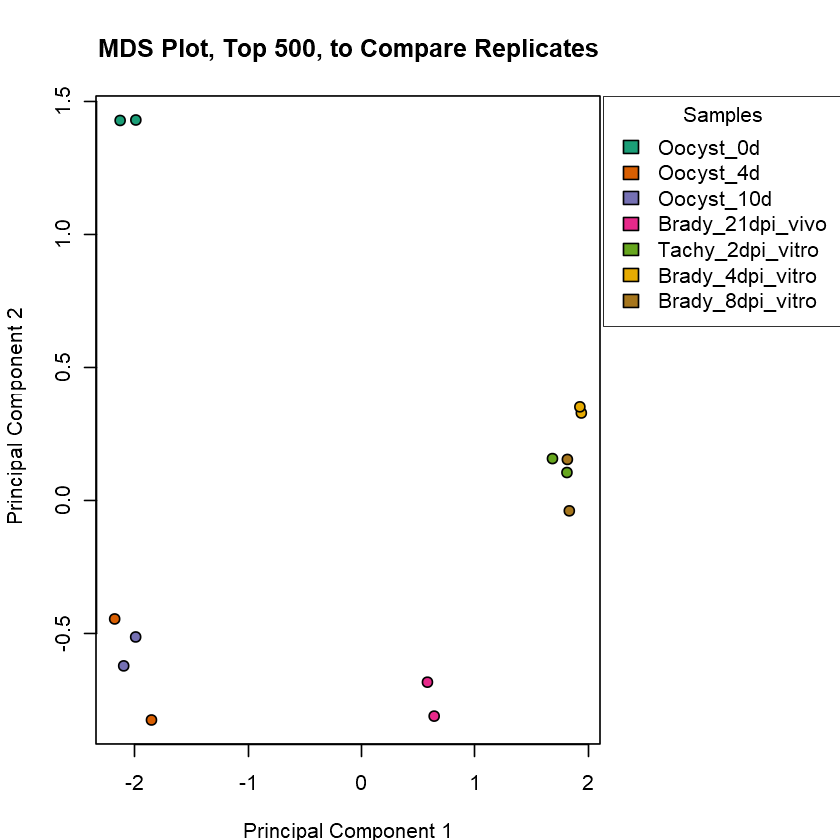

In [126]:
# svg("results/SamplesPlot/PCA_Plot.svg")
par(mar=c(4,4,4,10),xpd=TRUE)
limma::plotMDS(exprs(my.rma),top=500, pch=rep(21, 7), 
         bg=sample.color, gene.selection="common", 
        main="MDS Plot, Top 500, to Compare Replicates",
#         labels=unique(pData(my.rma)$group),
              )

legend("topright",title="Samples",inset=c(-0.48,0),box.lwd=0.5, 
       legend=unique(pData(my.rma)$group), fill=group.color)
# dev.off()


### Hierarchical Clustering

`z-score = (rma-sample - rma-mean) / rma-sd`

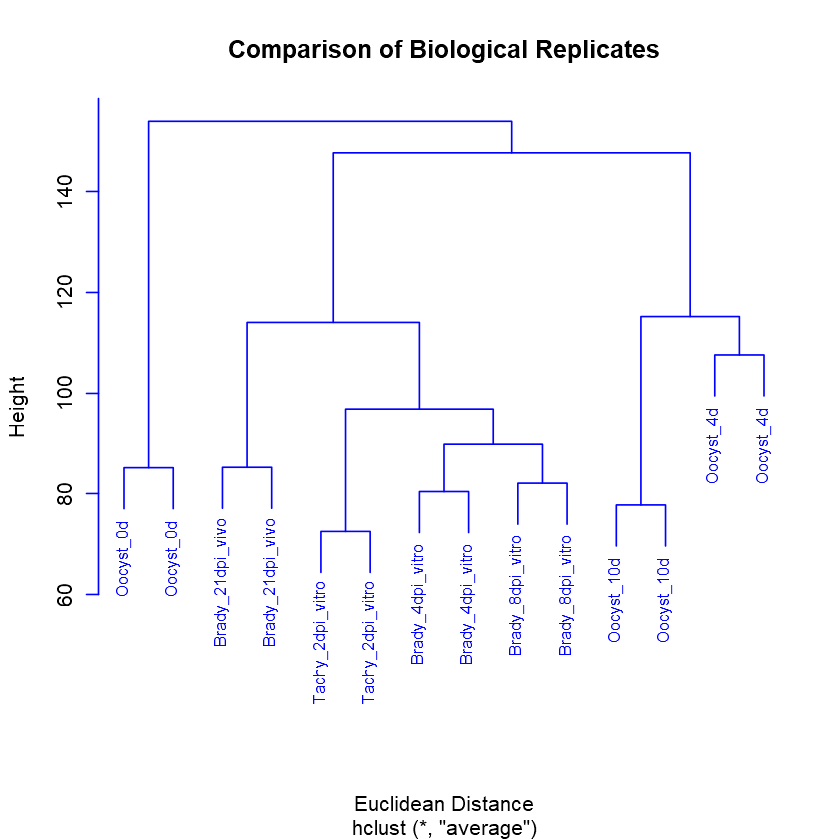

In [131]:
# cal z-score
cluster.dat <- exprs(my.rma)
gene.mean <- apply(cluster.dat, 1, mean)
gene.sd <- apply(cluster.dat, 1, sd)
cluster.dat <- sweep(cluster.dat, 1, gene.mean, "-")
cluster.dat <- sweep(cluster.dat, 1, gene.sd, "/")

my.dist <- dist(t(cluster.dat), method="euclidean")
my.hclust <- hclust(my.dist, method="average")
my.hclust$labels <- pData(my.rma)$group
# svg("results/SamplesPlot/HierarchicalPlot.svg")
plot(my.hclust, cex=0.75,col="blue",
     main="Comparison of Biological Replicates", 
      xlab="Euclidean Distance")
# dev.off()

### Removing Low Expression Data

To reduce the possibility for type I errors is to do fewer comparisons. This can be done by filtering the data. For example, we know that not all genes are expressed in all tissues and many genes will not be expressed in any sample. As a result, DGE analysis, it makes sense to remove probesets for genes that likely not expressed at all.

In [23]:
table(exprs(my.rma)<0)


 FALSE 
125902 

no genes have expression zero

In [24]:
as.numeric(quantile(exprs(my.rma), c(0., 0.025, 0.05, 0.075, 0.099, .10), na.rm=T))

[1] 1.721889 2.894521 3.049562 3.152091 3.231345 3.234123

***We now have the metadata and phenodata (sample data) for this experiment. The expression data is in format that could be used for differential gene expression (DGE) analysis.***

# DGE with Limma

In [25]:
# check if rows of phenotype is sorted same way as columns of exprs matrix
table(rownames(pData(my.rma))==colnames(exprs(my.rma)))


TRUE 
  14 

## Design Matrix

In [133]:
# prepare design matrix
sample.lst<-pData(my.rma)$group
group.lst<-factor(sample.lst)

my.design <- model.matrix(~0 + group, pData(my.rma))

rownames(my.design) <- sample.lst
colnames(my.design) <- levels(group.lst)

my.design

,Brady_21dpi_vivo,Brady_4dpi_vitro,Brady_8dpi_vitro,Oocyst_0d,Oocyst_10d,Oocyst_4d,Tachy_2dpi_vitro
Oocyst_0d,0,0,0,1,0,0,0
Oocyst_0d,0,0,0,1,0,0,0
Oocyst_4d,0,0,0,0,0,1,0
Oocyst_4d,0,0,0,0,0,1,0
Oocyst_10d,0,0,0,0,1,0,0
Oocyst_10d,0,0,0,0,1,0,0
Brady_21dpi_vivo,1,0,0,0,0,0,0
Brady_21dpi_vivo,1,0,0,0,0,0,0
Tachy_2dpi_vitro,0,0,0,0,0,0,1
Tachy_2dpi_vitro,0,0,0,0,0,0,1


In [27]:
# fit linear model
fit <- lmFit(my.rma, my.design)

In [28]:
# specify the comparison btw group of interest
my.contrasts <- makeContrasts(Oocyst_4vs0d = Oocyst_4d-Oocyst_0d, 
                            Oocyst_10vs0d = Oocyst_10d-Oocyst_0d,
                            Tachy_2dpi_vitro_vs_Oocyst_0d = Tachy_2dpi_vitro-Oocyst_0d,
                            Brady_4dpi_vitro_vs_Oocyst_0d = Brady_4dpi_vitro-Oocyst_0d,
                            Brady_8dpi_vitro_vs_Oocyst_0d = Brady_8dpi_vitro-Oocyst_0d,
                            Brady_21dpi_vivo_vs_Oocyst_0d = Brady_21dpi_vivo-Oocyst_0d
                            , levels = my.design)
my.contrasts

,Oocyst_4vs0d,Oocyst_10vs0d,Tachy_2dpi_vitro_vs_Oocyst_0d,Brady_4dpi_vitro_vs_Oocyst_0d,Brady_8dpi_vitro_vs_Oocyst_0d,Brady_21dpi_vivo_vs_Oocyst_0d
Brady_21dpi_vivo,0,0,0,0,0,1
Brady_4dpi_vitro,0,0,0,1,0,0
Brady_8dpi_vitro,0,0,0,0,1,0
Oocyst_0d,-1,-1,-1,-1,-1,-1
Oocyst_10d,0,1,0,0,0,0
Oocyst_4d,1,0,0,0,0,0
Tachy_2dpi_vitro,0,0,1,0,0,0


In [29]:
# store comparison matrix
write.table(my.contrasts, file=paste0("results/",my.gse,"_Comparisons.txt"), 
            sep="\t", quote=F,col.names=NA)

## Statistical Inference

In [30]:
fits.fun<-function(x)(contrasts.fit(fit, contrasts=my.contrasts[, x]));

contrast.fits <- lapply(colnames(my.contrasts),fits.fun)
names(contrast.fits)<-colnames(my.contrasts)

In [31]:
ebs.fun<-function(x)(eBayes(x, proportion=0.1, trend=FALSE, robust=FALSE))
    
contrast.ebs <- lapply(contrast.fits, ebs.fun)

In [32]:
tts.fun<-function(x)(topTable(x, adjust.method="BH", number=length(x$coefficients), sort.by="none"));

contrast.tts <- lapply(contrast.ebs,tts.fun)

In [33]:
test.fun<-function(x){
    store<-decideTests(x, method="separate", 
                                  adjust.method="BH", p.value=0.05, 
                                  lfc=0)
    return(store)
};

contrast.tests <- lapply(contrast.ebs, test.fun)


In [34]:
contrast.tests.df<-lapply(contrast.tests,function(x){
    store<-as.data.frame(x)
    colnames(store)<-"test"
    return(store)
})

In [35]:
head(contrast.tests.df[[1]])

,test
,<dbl>
1.m00014_at,0
10.m00080_s_at,-1
10.m00081_at,0
100.m00002_at,0
100.m00002_x_at,0
107.m00007_s_at,1


In [36]:
# show in one matrix whether up or down regulated in diff comparisons
tests.mat <- do.call(cbind, contrast.tests)
colnames(tests.mat) <- names(contrast.tests)
write.table(tests.mat, file=paste0("results/",my.gse,"_Test.txt"), 
            sep="\t", quote=F, col.names=NA)

In [37]:
head(tests.mat,3)

,Oocyst_4vs0d,Oocyst_10vs0d,Tachy_2dpi_vitro_vs_Oocyst_0d,Brady_4dpi_vitro_vs_Oocyst_0d,Brady_8dpi_vitro_vs_Oocyst_0d,Brady_21dpi_vivo_vs_Oocyst_0d
1.m00014_at,0,0,1,1,1,1
10.m00080_s_at,-1,-1,-1,-1,-1,0
10.m00081_at,0,0,0,0,0,0


# Gene Annotations for Microarray Probesets

In [38]:
gpl <- fetch.geo.data("GPL16542")
head(Meta(gpl))

Warning message in download.file(myurl, destfile, mode = mode, quiet = TRUE, method = getOption("download.file.method.GEOquery")):
"cannot open URL 'https://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16nnn/GPL16542/annot/GPL16542.annot.gz': HTTP status was '404 Not Found'"
Annotation GPL not available, so will use submitter GPL instead

Using locally cached version of GPL16542 found here:
./GPL16542.soft 



$contact_address
[1] "9000 Rockville Pike"

$contact_city
[1] "Bethesda"

$contact_country
[1] "USA"

$contact_email
[1] "geo@ncbi.nlm.nih.gov"

$contact_institute
[1] "NCBI/NLM/NIH"

$contact_name
[1] "GEO,,admin"

In [39]:
platform<- Table(gpl)[,c(1,2)]
head(platform)

,ID,ToxoDB_ID
,<chr>,<chr>
1,1.m00014_at,1.m00014
2,10.m00080_s_at,10.m00080
3,10.m00081_at,10.m00081
4,100.m00002_at,100.m00002
5,100.m00002_x_at,100.m00002
6,107.m00007_s_at,107.m00007


In [40]:
toxo.db<-read.table("results/ToxoDB.txt",header=T,sep="\t",quote="")
toxo.db<-toxo.db[,extract_from_vector(c("Gene.ID","Input.ID","Symbol"),colnames(toxo.db))]
head(toxo.db)

,Gene.ID,Input.ID,Gene.Name.or.Symbol
,<chr>,<chr>,<chr>
1,TGME49_200010,1.m00014,N/A
2,TGME49_200110,2.m00067,N/A
3,TGME49_200230,8.m00176,MIC17C
4,TGME49_200270,8.m00179,N/A
5,TGME49_200280,8.m00180,N/A
6,TGME49_200290,8.m00181,ROM1


In [41]:
colnames(toxo.db)[2]<-"ToxoDB_ID"
head(toxo.db,2)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol
,<chr>,<chr>,<chr>
1,TGME49_200010,1.m00014,N/A
2,TGME49_200110,2.m00067,N/A


In [42]:
new_toxo.db<-merge(toxo.db, platform, by="ToxoDB_ID",all.x=FALSE)
head(new_toxo.db,5)

,ToxoDB_ID,Gene.ID,Gene.Name.or.Symbol,ID
,<chr>,<chr>,<chr>,<chr>
1,1.m00014,TGME49_200010,N/A,1.m00014_at
2,107.m00010,TGME49_296640,SRS48E,107.m00010_at
3,113.m00001,TGME49_297120,N/A,113.m00001_at
4,113.m00009,TGME49_297960,RON6,113.m00009_at
5,113.m00012,TGME49_297500,N/A,113.m00012_at


In [43]:
# get annotation 
# gene.data <- select(org.Hs.eg.db, 
#                 keys=rownames(contrast.tts[[1]]), 
#                 keytype="ACCNUM", 
#                 columns=c("ENTREZID", "GENENAME", "SYMBOL","ENSEMBL"))
# gene.data<-na.omit(gene.data)

my.annotated.results<-lapply(colnames(my.contrasts),function(x){  
    store<-merge(contrast.tts[[x]], contrast.tests.df[[x]], by="row.names",all.x=FALSE)
    colnames(store)[1]<-"ID"

    store<-merge(new_toxo.db, store, by="ID")
    return(store)
})
names(my.annotated.results)<-colnames(my.contrasts)

In [44]:
head(my.annotated.results[[1]],3)

,ID,ToxoDB_ID,Gene.ID,Gene.Name.or.Symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B,test
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.m00014_at,1.m00014,TGME49_200010,N/A,-0.51637492,4.917772,-2.3256608,3.280897e-02,0.073947646,-2.140649,0
2,107.m00010_at,107.m00010,TGME49_296640,SRS48E,0.04367966,3.048206,0.2242675,8.252504e-01,0.892755559,-4.575188,0
3,113.m00001_at,113.m00001,TGME49_297120,N/A,-1.34791445,5.417085,-5.6539279,2.973517e-05,0.000158585,4.749932,-1


## Cases of genes with two or more probes, only the most significant ones were used.

In [45]:
my.unique.results <- lapply(colnames(my.contrasts), function(x){
    ordered.result<-my.annotated.results[[x]][order(my.annotated.results[[x]]$Gene.ID,
              my.annotated.results[[x]]$adj.P.Val,decreasing=FALSE),]
    return(ordered.result[!duplicated(ordered.result$Gene.ID),])
})
names(my.unique.results) <- colnames(my.contrasts)

In [46]:
# check if duplication still exists
print(length(my.unique.results[[2]]$Gene.ID))
table(duplicated(my.unique.results[[1]]$Gene.ID))

[1] 6894



FALSE 
 6894 

## Combine different time point comparison of a strain

In [47]:
names(my.unique.results)

[1] "Oocyst_4vs0d"                  "Oocyst_10vs0d"                
[3] "Tachy_2dpi_vitro_vs_Oocyst_0d" "Brady_4dpi_vitro_vs_Oocyst_0d"
[5] "Brady_8dpi_vitro_vs_Oocyst_0d" "Brady_21dpi_vivo_vs_Oocyst_0d"

In [48]:
store.list<-my.unique.results
names<-names(store.list)    
for(x in names){
#     1st comparison
    if(which(x==names)==1){
        combined<-store.list[[x]][,c("ToxoDB_ID","Gene.ID","Gene.Name.or.Symbol","logFC","test")]
        colnames(combined)[4:5]<-paste(x,c("logFC","test"),sep="_")
        } 
    else{
        colnames(store.list[[x]])<-paste(x,colnames(store.list[[x]]),sep="_")
        colnames(store.list[[x]])[which(colnames(store.list[[x]])==paste(x,"Gene.ID",sep="_"))]<-c("Gene.ID")
        combined<-merge(combined,store.list[[x]][,c(c("Gene.ID"),paste(x,c("logFC","test"),sep="_"))],by="Gene.ID")
        }
}

In [49]:
head(combined,3)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_200010,1.m00014,N/A,-0.5163749,0,0.3266450,0,2.18257031,1,1.3365857,1,1.5558629,1,1.1933009,1
2,TGME49_200110,2.m00067,N/A,-0.3775592,0,-0.2273754,0,0.03770051,0,0.3049947,0,0.1732012,0,0.1944254,0
3,TGME49_200230,8.m00176,MIC17C,4.2744421,1,2.3611348,1,0.56573854,1,1.7466108,1,2.2760369,1,3.0574758,1


## Filter genes that are significant in atleast one comparison

In [50]:
store.test<- 1*(combined[,grep("test",colnames(combined))]!=0)
# select genes that was significant in atleast one time point 
filtered<-combined[apply(store.test,1,sum)>=1,]
store.logFC<-filtered[,grep("logFC",colnames(filtered))]
# sort genes according in logFC
significant.genes<-filtered[order(apply(store.logFC,1,sum),decreasing=TRUE),]

In [51]:
head(significant.genes,3)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1771,TGME49_227620,42.m00015,GRA2,3.438593,1,3.500705,1,4.432393,1,4.179025,1,4.160219,1,4.028336,1
4430,TGME49_270250,59.m00089,GRA1,4.654261,1,4.387700,1,3.787647,1,3.409248,1,3.458667,1,4.016404,1
5135,TGME49_286450,76.m00004,GRA5,4.038114,1,3.957388,1,3.588724,1,3.749075,1,3.406961,1,3.824792,1


In [52]:
# store results
write.table(significant.genes, 
            file=paste0("results/","SignificantGenes.txt"), 
                sep="\t", quote=F, row.names=FALSE)

# Visualizing the Results

The function plotMA will produce a scatter plot of average log2 expression on the x-axis vs. log2 fold change on the y-axis.

## MAPlot 

In [53]:
create.folders("results/SamplesPlot/MAPlot")

[1] FALSE

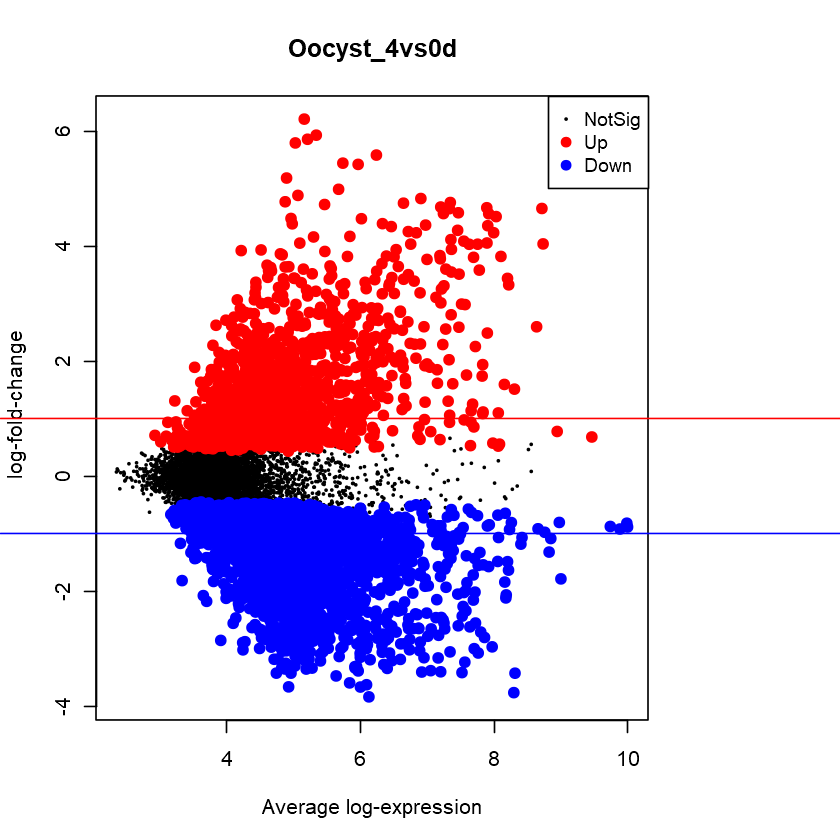

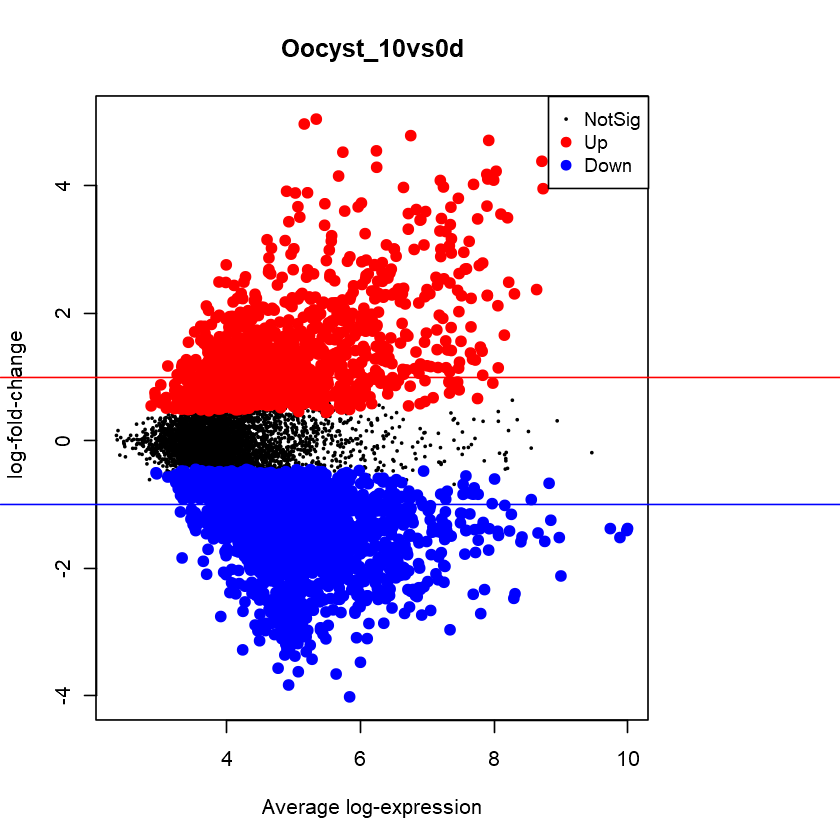

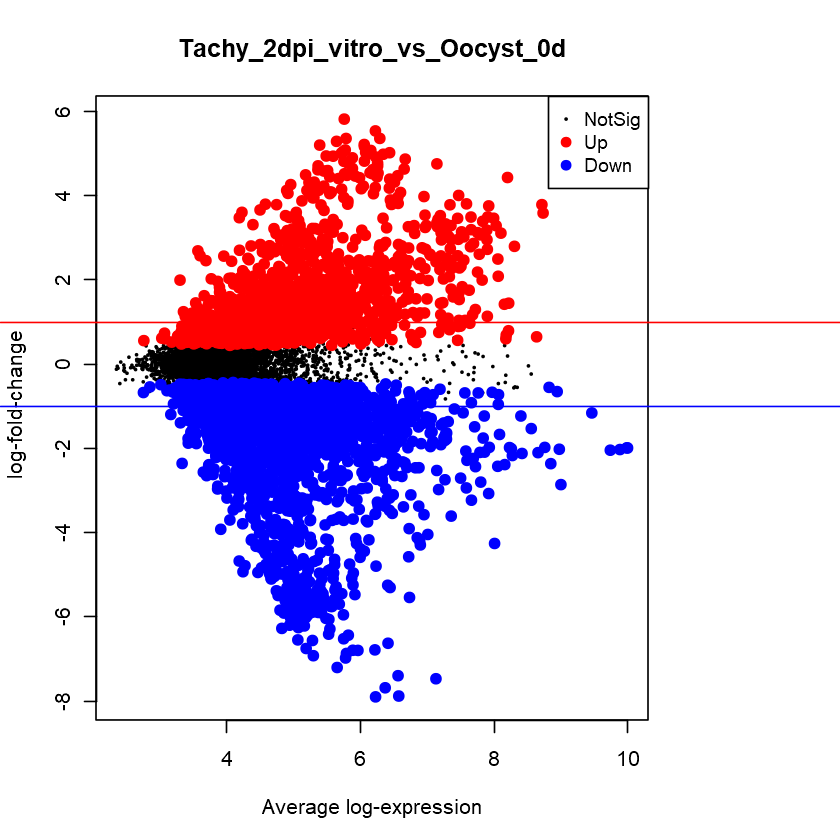

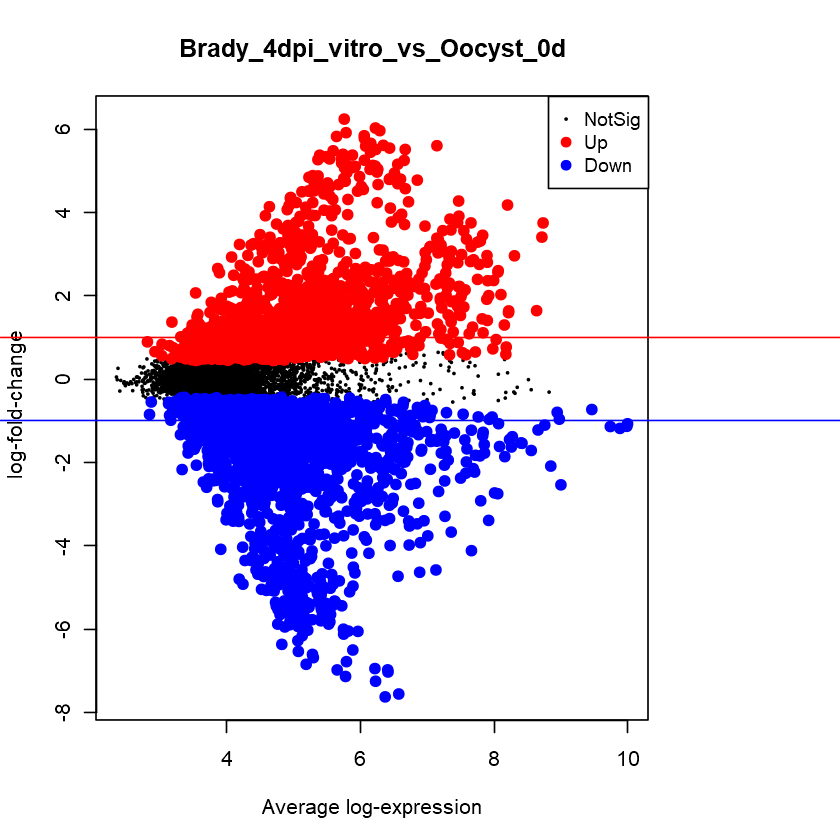

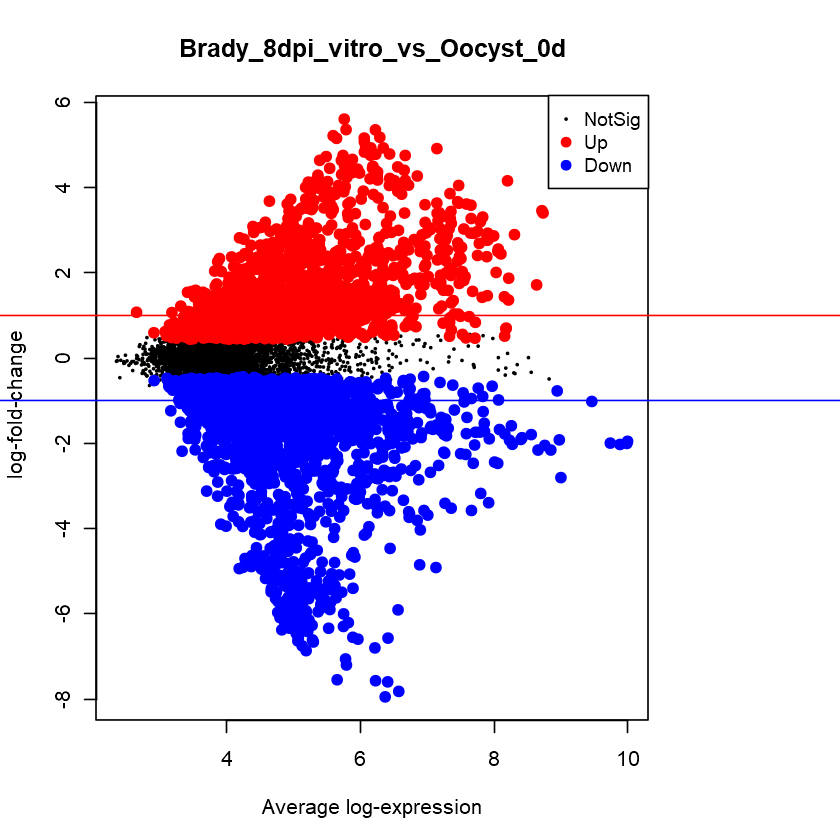

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

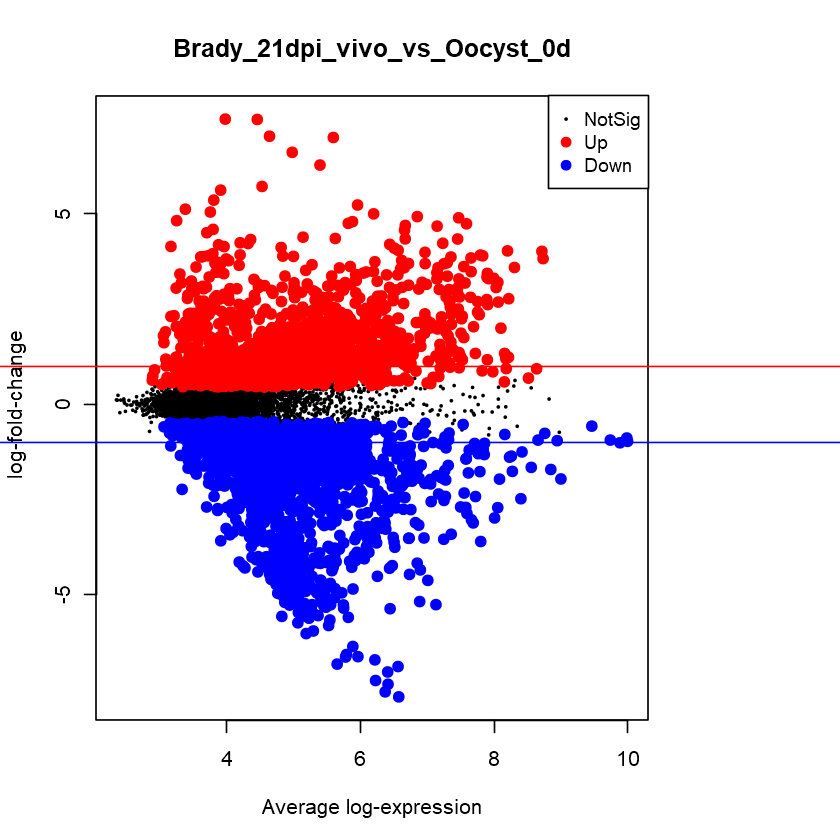

In [149]:
# chosing different color for up, down and not regulated probes, using tests 1,-1,0 marking.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#         svg(file=paste0("results/SamplesPlot/MAPlot/",x,"_MAPlot.svg"))  
    par(mar=c(5,4,4,8),xpd=TRUE)
        # assign above color to the rows,probeids.
    row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
    limma::plotMA(contrast.ebs[[x]], status=contrast.tests[[x]],
                col=row.colors, pch=19, main=x)  
        abline(h=1,col="red")
        abline(h=-1,col="blue" )
#         dev.off()
    })

## Volcano Plot

volcano plot which plot logFC on the x-axis and p-value (-log10) on the y-axis.

In [55]:
create.folders("results/SamplesPlot/VolcanoPlot")

[1] FALSE

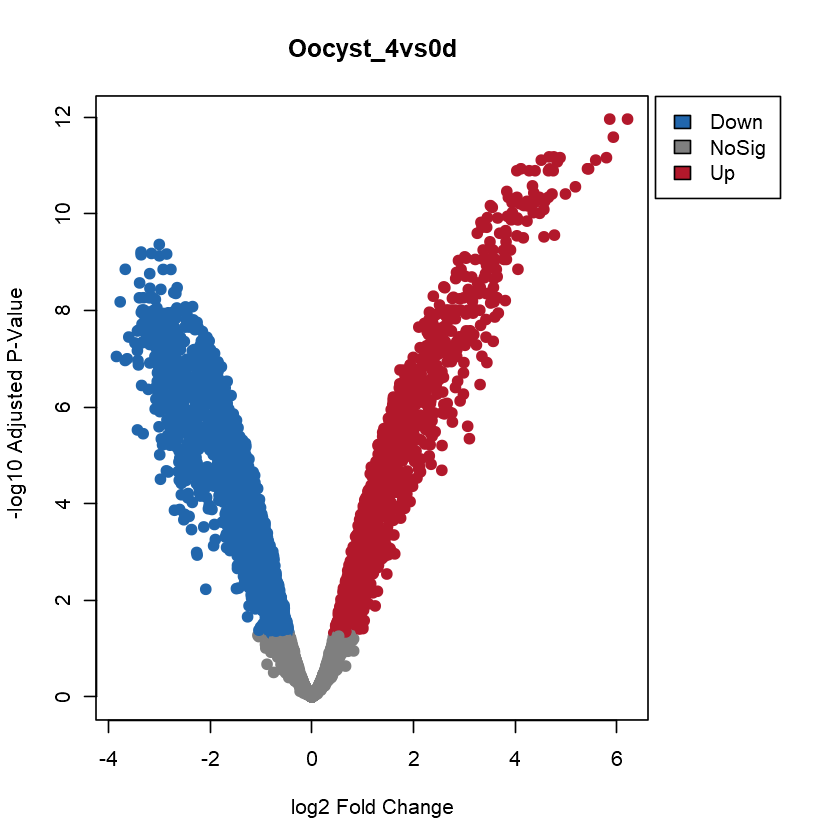

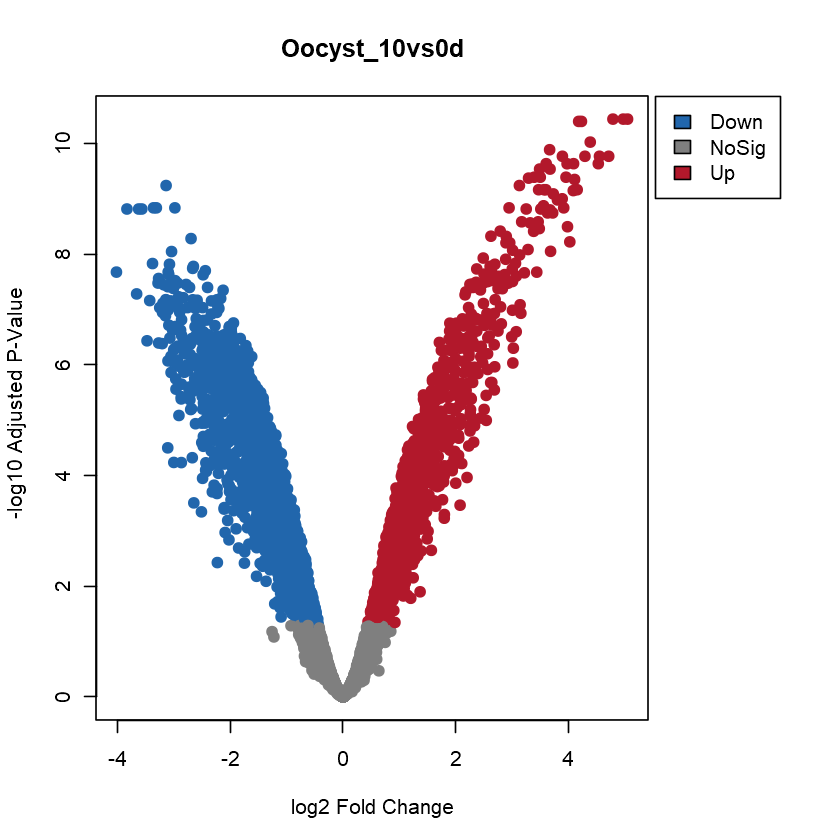

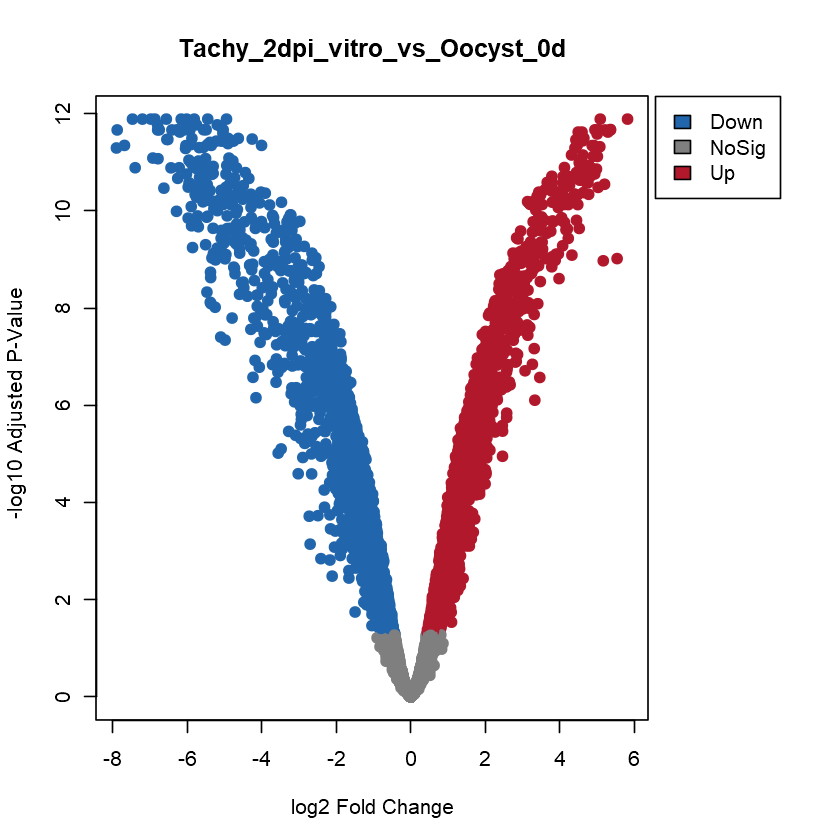

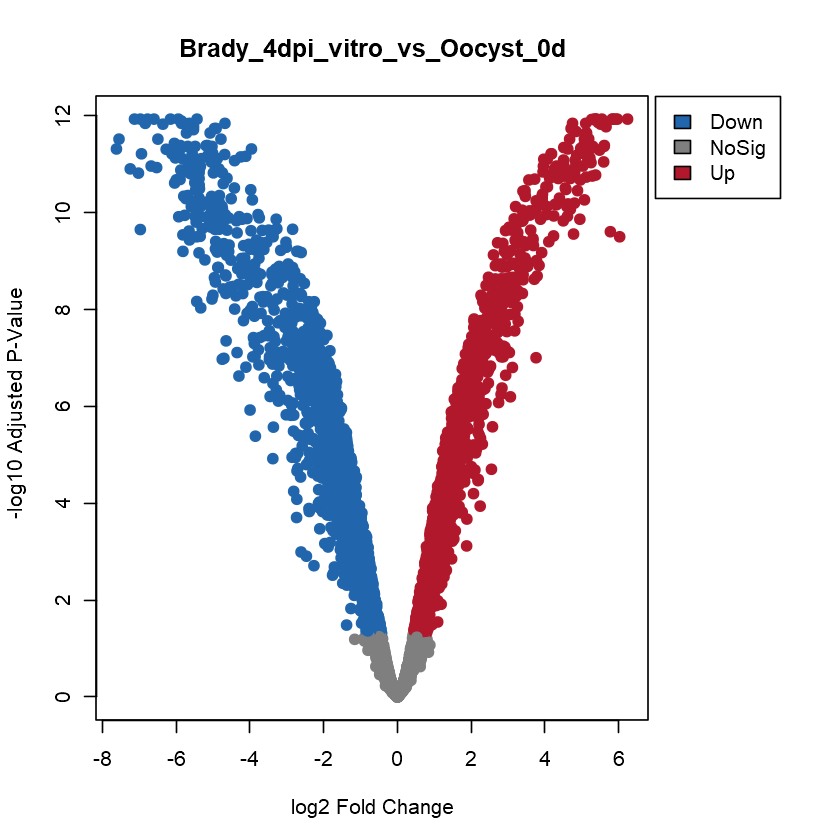

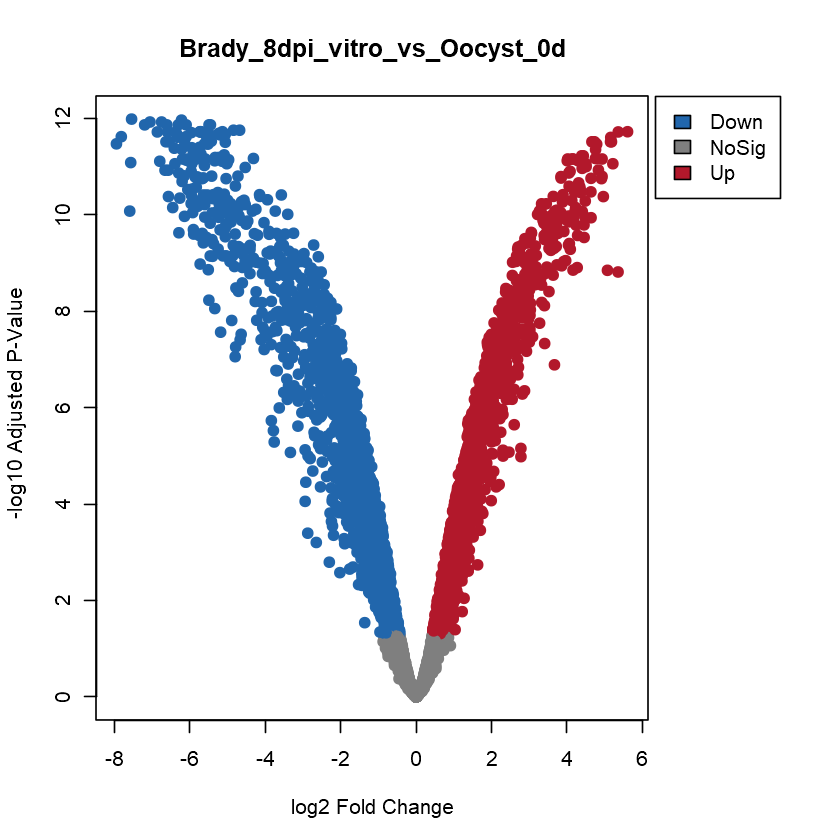

[[1]]
[[1]]$rect
[[1]]$rect$w
[1] 2.460635

[[1]]$rect$h
[1] 2.123685

[[1]]$rect$left
[1] 6.75556

[[1]]$rect$top
[1] 12.44073


[[1]]$text
[[1]]$text$x
[1] 7.824049 7.824049 7.824049

[[1]]$text$y
[1] 11.90980 11.37888 10.84796



[[2]]
[[2]]$rect
[[2]]$rect$w
[1] 2.220476

[[2]]$rect$h
[1] 1.853514

[[2]]$rect$left
[1] 5.542796

[[2]]$rect$top
[1] 10.85806


[[2]]$text
[[2]]$text$x
[1] 6.507 6.507 6.507

[[2]]$text$y
[1] 10.394680  9.931301  9.467923



[[3]]
[[3]]$rect
[[3]]$rect$w
[1] 3.359384

[[3]]$rect$h
[1] 2.110612

[[3]]$rect$left
[1] 6.565469

[[3]]$rect$top
[1] 12.36404


[[3]]$text
[[3]]$text$x
[1] 8.024225 8.024225 8.024225

[[3]]$text$y
[1] 11.83638 11.30873 10.78108



[[4]]
[[4]]$rect
[[4]]$rect$w
[1] 3.393322

[[4]]$rect$h
[1] 2.118457

[[4]]$rect$left
[1] 6.994001

[[4]]$rect$top
[1] 12.41003


[[4]]$text
[[4]]$text$x
[1] 8.467494 8.467494 8.467494

[[4]]$text$y
[1] 11.88042 11.35080 10.82119



[[5]]
[[5]]$rect
[[5]]$rect$w
[1] 3.319239

[[5]]$rect$h
[1] 2.127615

[[5]]$rect$left
[1] 6.34546

[[5]]$rect$top
[1] 12.46367


[[5]]$text
[[5]]$text$x
[1] 7.786784 7.786784 7.786784

[[5]]$text$y
[1] 11.93176 11.39986 10.86795



[[6]]
[[6]]$rect
[[6]]$rect$w
[1] 3.711718

[[6]]$rect$h
[1] 2.315786

[[6]]$rect$left
[1] 8.31036

[[6]]$rect$top
[1] 13.566


[[6]]$text
[[6]]$text$x
[1] 9.922111 9.922111 9.922111

[[6]]$text$y
[1] 12.98705 12.40810 11.82916

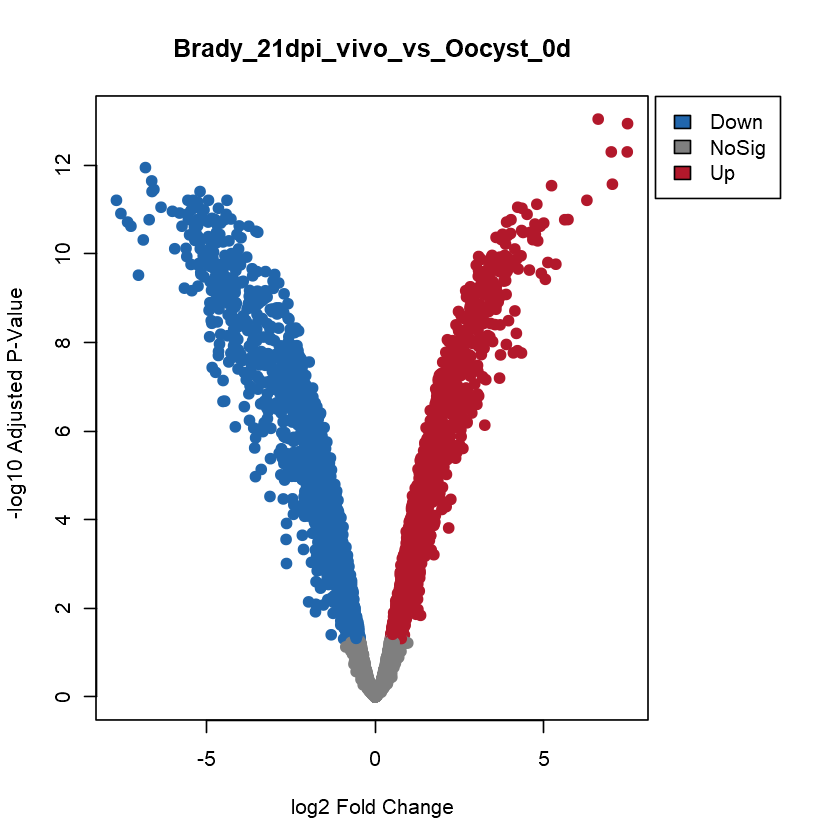

In [148]:
# chosing different color for up, down and not regulated probes.
ma.cols <- c(brewer.pal(11, "RdBu")[10], "grey50", brewer.pal(11, "RdBu")[2])
names(ma.cols)<-c(-1,0,1)

names<-names(my.unique.results)
lapply(names,function(x){
    
#         svg(file=paste0("results/SamplesPlot/VolcanoPlot/",x,"_VolcanoPlot.svg"))
        par(mar=c(5,4,4,8),xpd=TRUE)
        
        legend<-c("Down","NoSig","Up")  
        row.colors <- unname(ma.cols[as.character(contrast.tests[[x]][, 1])])
        
        plot(contrast.tts[[x]]$logFC, 
             -log10(contrast.tts[[x]]$adj.P.Val), 
             col=row.colors, pch=19, main=x, 
             xlab="log2 Fold Change", ylab="-log10 Adjusted P-Value")
#         abline(h=-log10(0.05))
#         abline(v=1,col="red")
#         abline(v=-1,col="blue")
        legend("topright",inset=c(-0.24,0), legend=legend, 
               fill=unname(ma.cols))
#         dev.off()
    })

## Histone and associated Genes

In [57]:
filter_genes<-read.table(file=paste0("assets/histone_related_genes.txt")
                              ,header=T,sep="\t",quote="")

In [58]:
head(filter_genes,10)

,Gene.Name.or.Symbol,isHistoneEnzyme
,<chr>,<int>
1,GCN5A,1
2,GCN5B,1
3,HDAC1,1
4,HDAC2,1
5,HDAC3,1
6,HDAC5,1
7,MYSTA,1
8,MYSTB,1
9,SIR2,1


In [59]:
new_filter_genes<- merge(filter_genes,new_toxo.db,by="Gene.Name.or.Symbol")
head(new_filter_genes,3)

,Gene.Name.or.Symbol,isHistoneEnzyme,ToxoDB_ID,Gene.ID,ID
,<chr>,<int>,<chr>,<chr>,<chr>
1,AP2III1,0,52.m01544,TGME49_252370,52.m01544_at
2,AP2III2,0,52.m01583,TGME49_253380,52.m01583_at
3,AP2III3,0,129.m00257,TGME49_299150,129.m00257_at


In [60]:
filter_ids<-as.data.frame(new_filter_genes[!duplicated(new_filter_genes$Gene.ID),]$Gene.ID)
colnames(filter_ids)<-c("Gene.ID")
head(filter_ids)

,Gene.ID
,<chr>
1,TGME49_252370
2,TGME49_253380
3,TGME49_299150
4,TGME49_320700
5,TGME49_320680
6,TGME49_211720


In [61]:
combined_filter_genes<-merge(combined,filter_ids,by="Gene.ID")
head(combined_filter_genes,5)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_202230,20.m03703,HDAC5,1.0784934,1,1.3156164,1,0.5059929,0,0.4012351,0,0.0826171,0,0.6450192,0
2,TGME49_202490,20.m03722,AP2VIIA7,-0.8727921,-1,-1.0788617,-1,-0.7655035,-1,-0.9435666,-1,-0.8761218,-1,-0.7073690,-1
3,TGME49_203690,20.m03816,AP2VIIA5,-0.4475332,0,-0.4156011,0,-0.7405226,-1,-1.2035390,-1,-0.9096815,-1,-1.0098146,-1
4,TGME49_203710,20.m03817,AP2VIIA4,0.1029488,0,-0.2325817,0,0.2890355,0,0.3179921,0,0.7379475,1,0.4106464,0
5,TGME49_205650,20.m00367,AP2VIIA3,0.3739884,0,-0.2023472,0,1.5038196,1,1.6534687,1,1.5811440,1,1.3071966,1


In [69]:
getwd()

[1] "D:/biological data analysis/Parasites/Plasmodium falciparum 3D7/GSE32427"

In [70]:
write.table(combined_filter_genes, 
            file=paste0("results/",my.gse,"_HistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

In [63]:
significant_filter_genes<-merge(significant.genes,
                                          filter_ids,
                                           by="Gene.ID")
head(significant_filter_genes,5)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_202230,20.m03703,HDAC5,1.0784934,1,1.3156164,1,0.5059929,0,0.4012351,0,0.0826171,0,0.6450192,0
2,TGME49_202490,20.m03722,AP2VIIA7,-0.8727921,-1,-1.0788617,-1,-0.7655035,-1,-0.9435666,-1,-0.8761218,-1,-0.7073690,-1
3,TGME49_203690,20.m03816,AP2VIIA5,-0.4475332,0,-0.4156011,0,-0.7405226,-1,-1.2035390,-1,-0.9096815,-1,-1.0098146,-1
4,TGME49_203710,20.m03817,AP2VIIA4,0.1029488,0,-0.2325817,0,0.2890355,0,0.3179921,0,0.7379475,1,0.4106464,0
5,TGME49_205650,20.m00367,AP2VIIA3,0.3739884,0,-0.2023472,0,1.5038196,1,1.6534687,1,1.5811440,1,1.3071966,1


In [64]:
dim(significant_filter_genes)

[1] 52 15

In [71]:
write.table(significant_filter_genes, 
                file=paste0("results/",my.gse,"_SignificantHistoneRelatedGenes.txt"), 
            sep="\t", quote=F, row.names=FALSE)

# Heatmap

In [66]:
library("gplots")


Attaching package: 'gplots'


The following object is masked from 'package:IRanges':

    space


The following object is masked from 'package:S4Vectors':

    space


The following object is masked from 'package:stats':

    lowess




In [67]:
head(significant_filter_genes,2)

,Gene.ID,ToxoDB_ID,Gene.Name.or.Symbol,Oocyst_4vs0d_logFC,Oocyst_4vs0d_test,Oocyst_10vs0d_logFC,Oocyst_10vs0d_test,Tachy_2dpi_vitro_vs_Oocyst_0d_logFC,Tachy_2dpi_vitro_vs_Oocyst_0d_test,Brady_4dpi_vitro_vs_Oocyst_0d_logFC,Brady_4dpi_vitro_vs_Oocyst_0d_test,Brady_8dpi_vitro_vs_Oocyst_0d_logFC,Brady_8dpi_vitro_vs_Oocyst_0d_test,Brady_21dpi_vivo_vs_Oocyst_0d_logFC,Brady_21dpi_vivo_vs_Oocyst_0d_test
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TGME49_202230,20.m03703,HDAC5,1.0784934,1,1.315616,1,0.5059929,0,0.4012351,0,0.0826171,0,0.6450192,0
2,TGME49_202490,20.m03722,AP2VIIA7,-0.8727921,-1,-1.078862,-1,-0.7655035,-1,-0.9435666,-1,-0.8761218,-1,-0.7073690,-1


In [104]:
store<-significant_filter_genes
store<-store[,-grep("test",colnames(store))]
input<-data.matrix(store[,-c(1:3)])

# input.mean<-apply(input,1,mean)
# input.sd<-apply(input,1,sd)
# input <- sweep(input, 1, input.mean, "-")
# input <- sweep(input, 1, input.sd, "/")

colors<-c(c(brewer.pal(8,"Set1")),c(brewer.pal(5,"Set2")))
treatment_time_color<-c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[6])
strain_color<-c(rep(colors[7],2),rep(colors[8],1),rep(colors[9],2),rep(colors[10],1))


strain_names<-c(rep("Oocyst",2),rep("Tachy",1),rep("Brady_vitro",2),rep("Brady_vivo",1))

treatment_times<-c('4day','10day','2dpi','4dpi','8dpi','21dpi')
treatment_color_options<-unique(treatment_time_color )
strain_color_options<-unique(strain_color)

# Top genes heatmap
# dendrogram = c("both","row","column","none")
svg(file="results/SignificantHistoneRelatedHeatmap.svg")  
par(cex.main=0.8,mar=c(0,15,1.5,0))
heatmap.2(input, trace="column", tracecol="cyan", 
          col=bluered(100),
          labRow=store$Gene.Name.or.Symbol,
          labCol=strain_names,
          dendrogram = "row",Colv=NA,
          scale="column",
          cexRow=0.65,cexCol=1, 
          margins = c(5.8,12), main="Histone Related Genes",  
          ColSideColors=treatment_time_color
         )
# legend("topright",inset=c(0.01,0.0),legend=c("L.dono"),
#        fill=strain_color_options,cex=0.45,title="Strains",
#        box.lwd=0.5,text.width=0.15)
legend("topright",inset=c(0.4,0.09),legend=treatment_times,
       fill=treatment_color_options,cex=0.45,title="Time",
       box.lwd=0.5,text.width=0.15)
          
# for exporting svg etc
dev.off()

png 
  2

## Vienn Diagram

In [150]:
library("VennDiagram")

Loading required package: grid

Loading required package: futile.logger



In [157]:
head(my.unique.results[[1]][my.unique.results[[1]]$test!=0,"Gene.ID"])

[1] "TGME49_200230" "TGME49_200270" "TGME49_200290" "TGME49_200310"
[5] "TGME49_200320" "TGME49_200330"

In [159]:
set1 ＜- my.unique.results[[1]][my.unique.results[[1]]$test!=0,"Gene.ID"]
set2 ＜- my.unique.results[[2]][my.unique.results[[2]]$test!=0,"Gene.ID"]
set3 ＜- my.unique.results[[3]][my.unique.results[[3]]$test!=0,"Gene.ID"]
set4  <- new_filter_genes$Gene.ID

x<-list(set1, set2, set3, set4)
colors ＜- c("#6b7fff", "#c3db0f", "#ff4059", "#2cff21")#, "#de4dff")
cat.names<-c("4hr Oocyst","10hr Oocyst","2dpi Trachy","Histone")
filename<-c('results/HistonevennDiagram.tiff')
# Make Venn diagram from list of groups
venn.diagram(x = x ,
            category.names = cat.names,
            filename = filename,output=TRUE,
            height = 3000, width = 3000, resolution = 500, 
            imagetype = "tiff" ,
            scaled = FALSE,
            col = "black",
            fill = colors,
            cat.col = colors,
            cat.cex = 1,
            margin = 0.15,
            main = "Histone Significant Genes",
#             sub = "Featuring: rotation and external lines",
            main.cex = 2,
            sub.cex = 1
)

[1] 1

## ScatterPlot


In [2]:
# setwd('GSE32427_T.gondii/')
getwd()

[1] "D:/biological data analysis/Parasites/GSE32427_T.gondii"

In [3]:
library(ggplot2)

In [4]:
only.histo<-read.table("results/GSE32427_OnlyHistoneGenes_ggplot.txt",header=T,sep="\t",quote="")
head(only.histo)

,Symbol,logFC,test,stage
,<chr>,<dbl>,<int>,<chr>
1,GCN5A,-0.5150238,-1,Bradyzoite
2,GCN5B,-0.3017049,0,Bradyzoite
3,HDAC1,-0.9060612,-1,Bradyzoite
4,HDAC2,0.5310822,1,Bradyzoite
5,HDAC3,0.8948019,1,Bradyzoite
6,HDAC5,0.4012351,0,Bradyzoite


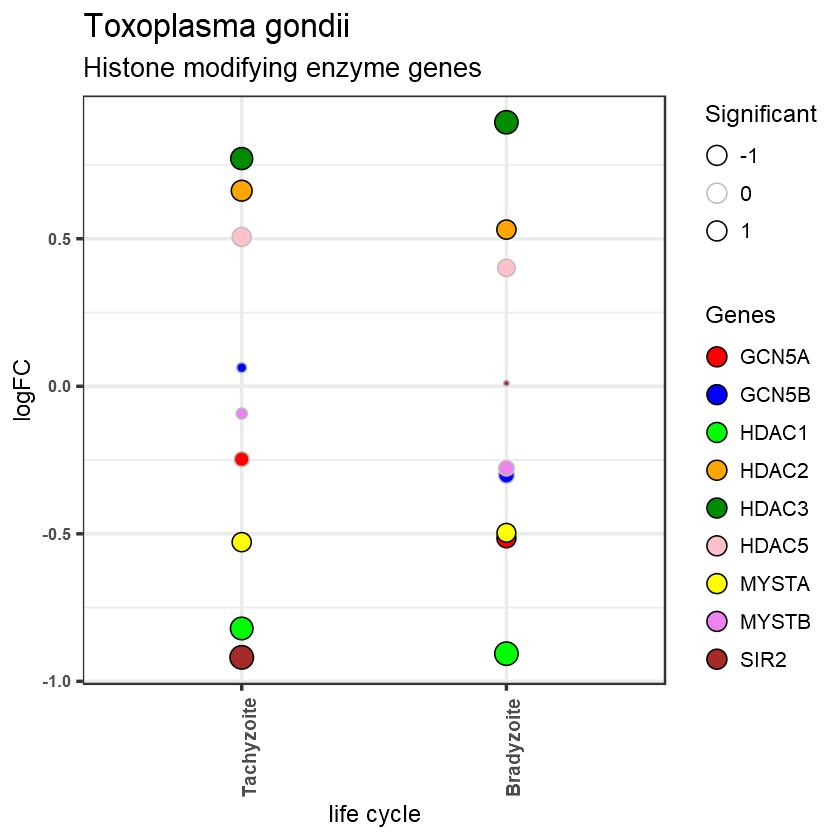

In [5]:
# svg(file="results/HistoneRelatedPLot.svg") 
# options(repr.plot.width=10,repr.plot.height=10)

theme_set(theme_bw(base_size = 16))  # pre-set the bw theme.
x_axis_order<-c('Tachyzoite','Bradyzoite')
size<-abs(only.histo$logFC)
Significant<-factor(only.histo$test)
Genes<-only.histo$Symbol
gene.cols <- c("GCN5A" = "red", "GCN5B" = "blue", "HDAC1" = "green", "HDAC2" = "orange",
              "HDAC3" = "green4", "HDAC5"="pink", "MYSTA"="yellow", "MYSTB"="violet", "SIR2"="brown")
g <- ggplot(only.histo, aes(factor(stage, level = x_axis_order),
                                   logFC))+
    geom_point(aes(fill=Genes,size=size,col=Significant),shape=21) +

    scale_colour_manual(values = c("black", "gray", "black"))+
    scale_fill_manual(values=gene.cols)+

    guides(size = FALSE, fill = guide_legend(override.aes = list(size=5)),
          color = guide_legend(override.aes = list(size=5)))+
    theme(axis.text.x = element_text(face="bold",size=11,angle=90),
          axis.text.y = element_text(face="bold",size=10),
          legend.title = element_text(color="black",size = 14),
          legend.text = element_text(color = "black", size = 12),
          legend.key.size = unit(0.8, "cm"),
#           legend.key.size = unit(3,"line"),
          legend.key.width = unit(0.5,"cm") ,
        axis.text=element_text(size=12),
        axis.title=element_text(size=14),
          
          )+
  labs(subtitle="Histone modifying enzyme genes", 
       y="logFC",
       x="life cycle",
       title="Toxoplasma gondii"
#        caption="life cycle"
      )
g
# dev.off()

In [6]:
# ggsave(file="results/OnlyHistonePlot.svg", plot=g, width=12, height=12)
ggsave(file="results/OnlyHistonePlot.svg", plot=g)

Saving 6.67 x 6.67 in image

